# FFT-OFDM vs DWT-OFDM

## Import Packages

In [5]:

import numpy as np
import pywt
import cv2
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
import scipy.fftpack

# Suppress PyWavelets warnings about exact reconstruction length
import warnings
warnings.filterwarnings("ignore", message="The wavelet w's filter length is 4. When input data length is 256, pywt.dwt_max_level will return 6. Max level should be a little less.")


## SYSTEM PARAMETERS

In [6]:

## ============================================================================================================== ##
##                                              SYSTEM PARAMETERS                                                ##
## ============================================================================================================== ##
N_SUBCARRIERS = 256   # Number of subcarriers (FFT size or DWT block size)
CP_RATIO = 1/4        # Cyclic Prefix ratio
CP_LENGTH = int(N_SUBCARRIERS * CP_RATIO)
K = 1                 # Number of users
M_ANTENNAS = 1        # Number of BS antennas. For Massive MIMO, M_ANTENNAS >> K.
MOD_ORDER_BITS = 2    # Modulation order in bits. 1 for BPSK, 2 for QPSK.
SNR_DB = 20           # Signal-to-noise ratio (dB) for the wireless channel.
WAVELET = 'db4'       # Wavelet type (e.g., 'db4' for Daubechies 4)

# Set the desired OFDM technique: 'FFT-OFDM' or 'DWT-OFDM'
OFDM_TECHNIQUE = 'DWT-OFDM' # Change this to switch between techniques "DWT-OFDM" and "FFT-OFDM"


## MODULATION & DEMODULATION

In [7]:

## ============================================================================================================== ##
##                                           MODULATION & DEMODULATION                                           ##
## ============================================================================================================== ##

def modulate_psk(bits, mod_order_bits):
    """
    Modulates an array of binary bits into PSK (Phase Shift Keying) symbols.
    """
    bits = bits.astype(int) 

    if mod_order_bits == 1: # BPSK
        return 2 * bits - 1
    elif mod_order_bits == 2: # QPSK
        bits_reshaped = bits.reshape(-1, 2)
        symbols = (2 * bits_reshaped[:, 0] - 1) + 1j * (2 * bits_reshaped[:, 1] - 1)
        return symbols / np.sqrt(2) 
    else:
        raise NotImplementedError(f"{2**mod_order_bits}-PSK/QAM not implemented. Only BPSK/QPSK.")

def demodulate_psk(rx_symbols, mod_order_bits):
    """
    Demodulates received PSK symbols back into binary bits.
    """
    if mod_order_bits == 1: # BPSK
        return (np.real(rx_symbols) > 0).astype(int)
    elif mod_order_bits == 2: # QPSK
        real_bits = (np.real(rx_symbols) > 0).astype(int)
        imag_bits = (np.imag(rx_symbols) > 0).astype(int)
        return np.stack((real_bits, imag_bits), axis=-1).flatten()
    else:
        raise NotImplementedError(f"{2**mod_order_bits}-PSK/QAM not implemented. Only BPSK/QPSK.")

def add_cyclic_prefix(ofdm_symbol, cp_length):
    """
    Adds a cyclic prefix to an OFDM/DWT-OFDM symbol.
    """
    return np.concatenate((ofdm_symbol[-cp_length:], ofdm_symbol))

def remove_cyclic_prefix(rx_ofdm_symbol, cp_length):
    """
    Removes the cyclic prefix from a received OFDM/DWT-OFDM symbol.
    """
    return rx_ofdm_symbol[cp_length:]


## TRANSMITTER FUNCTIONS

In [8]:

## ============================================================================================================== ##
##                                                 TRANSMITTER FUNCTIONS                                         ##
## ============================================================================================================== ##

def fft_ofdm_transmitter(data_symbols, N_subcarriers, cp_length):
    """
    Applies IFFT and adds CP for FFT-OFDM.
    """
    # Perform N-point IFFT to convert frequency-domain symbols to time-domain signal
    time_domain_symbol = scipy.fftpack.ifft(data_symbols, n=N_subcarriers)
    
    # Add Cyclic Prefix
    ofdm_symbol_with_cp = add_cyclic_prefix(time_domain_symbol, cp_length)
    return ofdm_symbol_with_cp

def dwt_ofdm_transmitter_block(data_symbols, N_subcarriers, wavelet_name, dwt_max_level, cp_length):
    """
    Applies DWT to real/imaginary parts of data_symbols and adds CP for DWT-OFDM.
    Returns the DWT-OFDM symbol and coefficient info for reconstruction.
    """
    real_part = data_symbols.real
    imag_part = data_symbols.imag

    # Perform multi-level DWT decomposition on real and imaginary parts
    coeffs_real = pywt.wavedec(real_part, wavelet_name, level=dwt_max_level)
    coeffs_imag = pywt.wavedec(imag_part, wavelet_name, level=dwt_max_level)
    
    # Store lengths of coefficient arrays for reconstruction at receiver
    current_coeff_lengths_real = [len(c) for c in coeffs_real]
    current_coeff_lengths_imag = [len(c) for c in coeffs_imag]
    
    # Flatten all DWT coefficient arrays into a single 1D array
    flattened_dwt_symbol = np.concatenate(coeffs_real + coeffs_imag)
    
    # Add Cyclic Prefix
    dwt_symbol_with_cp = add_cyclic_prefix(flattened_dwt_symbol, cp_length)

    coeff_info = {
        'dwt_max_level': dwt_max_level,
        'coeffs_real_lengths': current_coeff_lengths_real,
        'coeffs_imag_lengths': current_coeff_lengths_imag,
        'total_flattened_length': len(flattened_dwt_symbol)
    }
    return dwt_symbol_with_cp, coeff_info

def general_transmitter(image_path, N_subcarriers, K, mod_order_bits, cp_length, technique='FFT-OFDM', wavelet_name=None):
    """
    General transmitter function that supports both FFT-OFDM and DWT-OFDM.
    """
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Image not found at {image_path}")
    
    img_resized = cv2.resize(img, (N_subcarriers, N_subcarriers))
    img_flat_bytes = img_resized.flatten().astype(np.uint8)
    total_image_bits = np.unpackbits(img_flat_bytes)
    
    bits_per_modulated_symbol = mod_order_bits
    
    # Calculate total modulated symbols needed, ensure it's a multiple of N_subcarriers * K
    num_modulated_symbols = int(np.ceil(len(total_image_bits) / bits_per_modulated_symbol))
    
    symbols_per_ofdm_block_input = N_subcarriers
    num_blocks_needed_total = int(np.ceil(num_modulated_symbols / (symbols_per_ofdm_block_input * K))) * K 
    total_symbols_to_process = num_blocks_needed_total * symbols_per_ofdm_block_input
    
    padded_image_bits = np.pad(total_image_bits, (0, total_symbols_to_process * bits_per_modulated_symbol - len(total_image_bits)), 'constant')
    
    all_modulated_symbols = modulate_psk(padded_image_bits, mod_order_bits)

    tx_symbols_per_user_list = [[] for _ in range(K)]
    coeff_info_per_user_list = [[] for _ in range(K)] # Will only be populated for DWT-OFDM

    dwt_max_level = 0
    if technique == 'DWT-OFDM':
        if wavelet_name is None:
            raise ValueError("wavelet_name must be provided for DWT-OFDM.")
        dwt_max_level = pywt.dwt_max_level(N_subcarriers, wavelet_name)
        if dwt_max_level == 0:
            raise ValueError(f"Cannot decompose {N_subcarriers} with wavelet '{wavelet_name}'. "
                             "N_SUBCARRIERS must be large enough for at least one level of decomposition.")

    for i in range(0, len(all_modulated_symbols), K * N_subcarriers):
        for user_idx in range(K):
            start_idx = i + user_idx * N_subcarriers
            end_idx = start_idx + N_subcarriers
            user_modulated_block = all_modulated_symbols[start_idx:end_idx]
            
            if technique == 'FFT-OFDM':
                ofdm_symbol_with_cp = fft_ofdm_transmitter(user_modulated_block, N_subcarriers, cp_length)
                tx_symbols_per_user_list[user_idx].append(ofdm_symbol_with_cp)
                # For FFT-OFDM, coefficient info is not needed, but we keep the list structure consistent
                # A dummy entry indicates the block length for channel modeling.
                coeff_info_per_user_list[user_idx].append({
                    'total_flattened_length': N_subcarriers, # Length before CP
                })
            elif technique == 'DWT-OFDM':
                dwt_symbol_with_cp, coeff_info = dwt_ofdm_transmitter_block(user_modulated_block, N_subcarriers, wavelet_name, dwt_max_level, cp_length)
                tx_symbols_per_user_list[user_idx].append(dwt_symbol_with_cp)
                coeff_info_per_user_list[user_idx].append(coeff_info)
            else:
                raise ValueError("Invalid OFDM technique specified. Choose 'FFT-OFDM' or 'DWT-OFDM'.")
            
    final_tx_symbols_per_user = [np.concatenate(symbols) for symbols in tx_symbols_per_user_list]

    return final_tx_symbols_per_user, img_resized.shape, total_image_bits, coeff_info_per_user_list


## CHANNEL MODEL

In [9]:

## ============================================================================================================== ##
##                                                 CHANNEL MODEL                                                 ##
## ============================================================================================================== ##

def massive_mimo_channel(tx_symbols_per_user, M_antennas, K_users, SNR_dB, coeff_info_per_user_list, cp_length):
    """
    Simulates a realistic Massive MIMO wireless channel with Rayleigh fading and Additive White Gaussian Noise (AWGN).
    """
    if not tx_symbols_per_user or not tx_symbols_per_user[0].size > 0:
        raise ValueError("Transmitted symbols are empty, cannot determine block length for channel modeling.")
    
    signal_power_linear = 1 
    SNR_linear = 10**(SNR_dB / 10)
    noise_variance_per_dim = signal_power_linear / (2 * SNR_linear) 

    H_channel_real = np.random.randn(M_antennas, K_users) / np.sqrt(2)
    H_channel_imag = np.random.randn(M_antennas, K_users) / np.sqrt(2)
    H_channel = H_channel_real + 1j * H_channel_imag

    received_signals_at_antennas = [np.zeros_like(tx_symbols_per_user[0], dtype=complex) for _ in range(M_antennas)]

    # Determine the length of each transmitted block (before CP, then add CP_LENGTH)
    # This must be consistent for all users and all blocks.
    if coeff_info_per_user_list and coeff_info_per_user_list[0]:
        block_length_before_cp = coeff_info_per_user_list[0][0]['total_flattened_length']
        block_length_with_cp = block_length_before_cp + cp_length
    else:
        # Fallback for unexpected empty coeff_info_per_user_list. Should not happen if data is processed.
        # This fallback assumes block length is N_SUBCARRIERS if coeff_info isn't available (e.g. for simple FFT cases without explicit DWT info).
        block_length_with_cp = N_SUBCARRIERS + cp_length
        print("Warning: coeff_info_per_user_list was empty in channel model, used fallback for block length.")


    num_blocks = len(tx_symbols_per_user[0]) // block_length_with_cp

    for block_idx in range(num_blocks):
        current_tx_blocks = np.array([
            tx_symbols_per_user[user_idx][block_idx * block_length_with_cp : (block_idx + 1) * block_length_with_cp]
            for user_idx in range(K_users)
        ])

        for m_idx in range(M_antennas):
            received_block_at_m = np.zeros_like(current_tx_blocks[0], dtype=complex)
            for k_idx in range(K_users):
                received_block_at_m += H_channel[m_idx, k_idx] * current_tx_blocks[k_idx]
            
            noise_real = np.random.randn(*received_block_at_m.shape) * np.sqrt(noise_variance_per_dim)
            noise_imag = np.random.randn(*received_block_at_m.shape) * np.sqrt(noise_variance_per_dim)
            awgn = noise_real + 1j * noise_imag
            
            received_signals_at_antennas[m_idx][block_idx * block_length_with_cp : (block_idx + 1) * block_length_with_cp] = received_block_at_m + awgn

    return received_signals_at_antennas, H_channel, noise_variance_per_dim


## RECEIVER FUNCTIONS

In [10]:

## ============================================================================================================== ##
##                                                 RECEIVER FUNCTIONS                                            ##
## ============================================================================================================== ##

def fft_ofdm_receiver(rx_ofdm_symbol_no_cp, N_subcarriers):
    """
    Applies FFT to recover frequency-domain symbols for FFT-OFDM.
    """
    # Perform N-point FFT
    recovered_symbols = scipy.fftpack.fft(rx_ofdm_symbol_no_cp, n=N_subcarriers)
    return recovered_symbols

def dwt_ofdm_receiver_block(rx_dwt_symbol_no_cp, coeff_info, wavelet_name, N_subcarriers):
    """
    Applies IDWT to recover original complex symbols for DWT-OFDM.
    """
    dwt_max_level = coeff_info['dwt_max_level']
    coeffs_real_lengths = coeff_info['coeffs_real_lengths']
    coeffs_imag_lengths = coeff_info['coeffs_imag_lengths']

    real_part_flattened_len = sum(coeffs_real_lengths)
    estimated_flattened_real_coeffs = rx_dwt_symbol_no_cp[:real_part_flattened_len]
    estimated_flattened_imag_coeffs = rx_dwt_symbol_no_cp[real_part_flattened_len:]

    coeffs_real_rx = []
    current_start = 0
    for length in coeffs_real_lengths:
        coeffs_real_rx.append(estimated_flattened_real_coeffs[current_start : current_start + length])
        current_start += length
    
    coeffs_imag_rx = []
    current_start = 0
    for length in coeffs_imag_lengths:
        coeffs_imag_rx.append(estimated_flattened_imag_coeffs[current_start : current_start + length])
        current_start += length

    # Perform Inverse DWT
    demod_input_real = pywt.waverec(coeffs_real_rx, wavelet_name, mode='symmetric')
    demod_input_imag = pywt.waverec(coeffs_imag_rx, wavelet_name, mode='symmetric')
    
    # Ensure IDWT output matches N_subcarriers, handle potential small discrepancies
    if len(demod_input_real) != N_subcarriers:
        if len(demod_input_real) > N_subcarriers:
            demod_input_real = demod_input_real[:N_subcarriers]
        else:
            demod_input_real = np.pad(demod_input_real, (0, N_subcarriers - len(demod_input_real)), 'constant')
    
    if len(demod_input_imag) != N_subcarriers:
        if len(demod_input_imag) > N_subcarriers:
            demod_input_imag = demod_input_imag[:N_subcarriers]
        else:
            demod_input_imag = np.pad(demod_input_imag, (0, N_subcarriers - len(demod_input_imag)), 'constant')

    recovered_symbols_complex = demod_input_real + 1j * demod_input_imag
    return recovered_symbols_complex


def general_receiver(received_signals_at_antennas, H_channel, noise_variance_per_dim, original_img_shape, 
                     N_subcarriers, K_users, mod_order_bits, cp_length, coeff_info_per_user_list, total_image_bits_len, technique='FFT-OFDM', wavelet_name=None):
    
    # Determine symbol length based on technique and coefficient info
    if technique == 'DWT-OFDM':
        # DWT symbol length before CP is specific to DWT coefficients
        symbol_length_flat_coeffs = coeff_info_per_user_list[0][0]['total_flattened_length']
    else: # FFT-OFDM
        # FFT-OFDM symbol length before CP is simply N_subcarriers
        symbol_length_flat_coeffs = N_subcarriers 
        
    symbol_length_with_cp = symbol_length_flat_coeffs + cp_length
    
    H_hermitian = H_channel.conj().T
    
    effective_noise_power_for_mmse = 2 * noise_variance_per_dim 
    noise_term_for_mmse = effective_noise_power_for_mmse * np.eye(K_users)

    try:
        inv_term = np.linalg.inv(H_hermitian @ H_channel + noise_term_for_mmse)
    except np.linalg.LinAlgError:
        print("Warning: H_hermitian @ H_channel + noise_term is singular. Adding epsilon.")
        inv_term = np.linalg.inv(H_hermitian @ H_channel + noise_term_for_mmse + 1e-10 * np.eye(K_users)) 
        
    W_mmse = inv_term @ H_hermitian
    
    demodulated_bits_all_users = [[] for _ in range(K_users)]
    
    num_ofdm_blocks_per_user = len(received_signals_at_antennas[0]) // symbol_length_with_cp

    for block_idx in range(num_ofdm_blocks_per_user):
        rx_block_all_antennas_with_cp = np.array([
            rx_sig[block_idx * symbol_length_with_cp : (block_idx + 1) * symbol_length_with_cp]
            for rx_sig in received_signals_at_antennas
        ])
        
        estimated_flattened_ofdm_symbols_all_users = W_mmse @ rx_block_all_antennas_with_cp
        
        for user_idx in range(K_users):
            estimated_flattened_symbol_with_cp = estimated_flattened_ofdm_symbols_all_users[user_idx]
            estimated_flattened_symbol_no_cp = remove_cyclic_prefix(estimated_flattened_symbol_with_cp, cp_length)
            
            recovered_data_symbols = None
            if technique == 'FFT-OFDM':
                recovered_data_symbols = fft_ofdm_receiver(estimated_flattened_symbol_no_cp, N_subcarriers)
            elif technique == 'DWT-OFDM':
                if wavelet_name is None:
                    raise ValueError("wavelet_name must be provided for DWT-OFDM in receiver.")
                # Pass the correct coeff_info for the current block and user
                current_coeff_info = coeff_info_per_user_list[user_idx][block_idx] 
                recovered_data_symbols = dwt_ofdm_receiver_block(estimated_flattened_symbol_no_cp, current_coeff_info, wavelet_name, N_subcarriers)
            else:
                raise ValueError("Invalid OFDM technique specified. Choose 'FFT-OFDM' or 'DWT-OFDM'.")

            demodulated_bits = demodulate_psk(recovered_data_symbols.flatten(), mod_order_bits)
            demodulated_bits_all_users[user_idx].extend(demodulated_bits.tolist())
            
    final_demodulated_bits = np.concatenate([np.array(bits) for bits in demodulated_bits_all_users])
    final_demodulated_bits = final_demodulated_bits[:total_image_bits_len]

    pad_bits_for_bytes = (8 - (len(final_demodulated_bits) % 8)) % 8
    padded_demodulated_bits = np.pad(final_demodulated_bits, (0, pad_bits_for_bytes), 'constant')
    
    recovered_img_bytes = np.packbits(padded_demodulated_bits)
    expected_bytes_len = original_img_shape[0] * original_img_shape[1]
    
    if len(recovered_img_bytes) < expected_bytes_len:
        recovered_img_bytes = np.pad(recovered_img_bytes, (0, expected_bytes_len - len(recovered_img_bytes)), 'constant')
    elif len(recovered_img_bytes) > expected_bytes_len:
        recovered_img_bytes = recovered_img_bytes[:expected_bytes_len]
        
    recovered_img = recovered_img_bytes.reshape(original_img_shape)
    
    return recovered_img


## SIMULATION RUN

--- Running Simulation for DWT-OFDM ---
Parameters: N_SUBCARRIERS=256, CP_RATIO=0.25, K=1, M_ANTENNAS=1, SNR_DB=20
Wavelet: db4

Original image shape: (256, 256)
Total image bits: 524288
Transmitting 1024 blocks per user, each 640 samples (with CP).


/home/rg9828/anaconda3/lib/python3.11/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range ** 2) / err)



--- Performance for DWT-OFDM (SNR: 20 dB) ---
PSNR: inf dB
SSIM: 1.0000


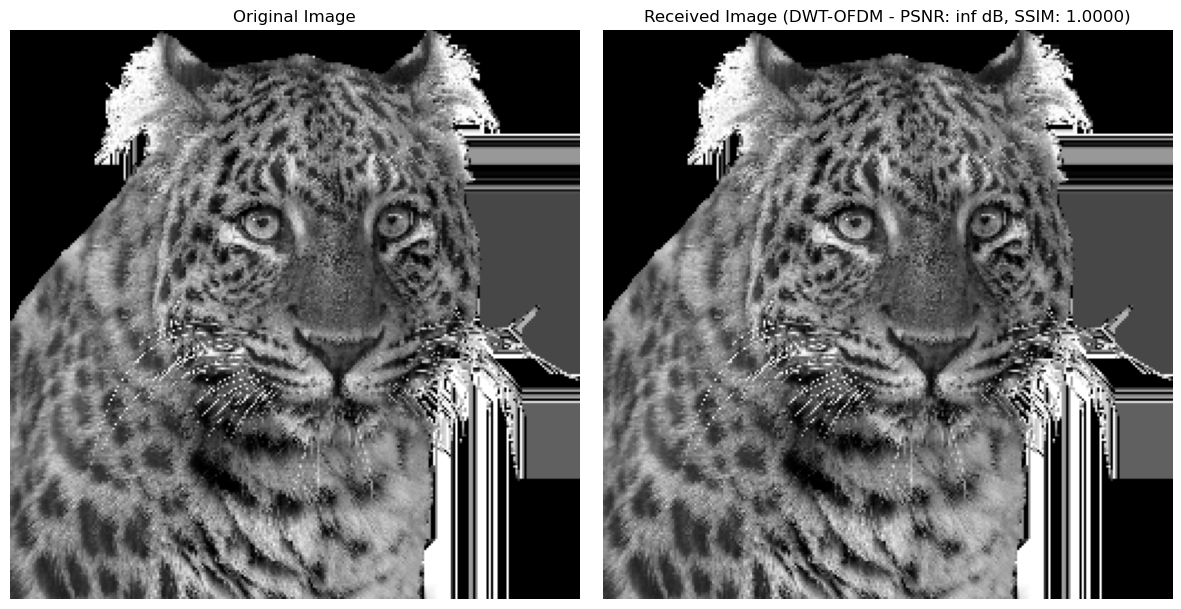

In [11]:

## ============================================================================================================== ##
##                                                  SIMULATION RUN                                               ##
## ============================================================================================================== ##

img_path = "/home/rg9828/Documents/Blogger/Physical_Layer/PHYSICAL_Layer/OFDM/panther.png"

print(f"--- Running Simulation for {OFDM_TECHNIQUE} ---")
print(f"Parameters: N_SUBCARRIERS={N_SUBCARRIERS}, CP_RATIO={CP_RATIO}, K={K}, M_ANTENNAS={M_ANTENNAS}, SNR_DB={SNR_DB}")
if OFDM_TECHNIQUE == 'DWT-OFDM':
    print(f"Wavelet: {WAVELET}")

try:
    # 1. TRANSMITTER
    tx_symbols_per_user, img_shape, total_image_bits, coeff_info_per_user_list = \
        general_transmitter(img_path, N_SUBCARRIERS, K, MOD_ORDER_BITS, CP_LENGTH, OFDM_TECHNIQUE, WAVELET if OFDM_TECHNIQUE == 'DWT-OFDM' else None)

    print(f"\nOriginal image shape: {img_shape}")
    print(f"Total image bits: {len(total_image_bits)}")
    
    # Get the actual symbol length (before CP) for display
    if coeff_info_per_user_list and coeff_info_per_user_list[0]:
        block_len_flat_coeffs = coeff_info_per_user_list[0][0]['total_flattened_length']
    else: # Fallback for FFT-OFDM if coeff_info isn't explicitly set with 'total_flattened_length'
        block_len_flat_coeffs = N_SUBCARRIERS
        
    block_len_with_cp = block_len_flat_coeffs + CP_LENGTH
    num_blocks_per_user = len(tx_symbols_per_user[0]) // block_len_with_cp
    print(f"Transmitting {num_blocks_per_user} blocks per user, each {block_len_with_cp} samples (with CP).")


    # 2. CHANNEL
    rx_signals_at_antennas, H_channel, noise_variance_per_dim = \
        massive_mimo_channel(tx_symbols_per_user, M_ANTENNAS, K, SNR_DB, coeff_info_per_user_list, CP_LENGTH) 

    # 3. RECEIVER
    recovered_img = general_receiver(
        rx_signals_at_antennas, H_channel, noise_variance_per_dim, img_shape, 
        N_SUBCARRIERS, K, MOD_ORDER_BITS, CP_LENGTH, coeff_info_per_user_list, len(total_image_bits), OFDM_TECHNIQUE, WAVELET if OFDM_TECHNIQUE == 'DWT-OFDM' else None
    )

    ## ============================================================================================================== ##
    ##                                                 EVALUATION & VISUALIZATION                                  ##
    ## ============================================================================================================== ##

    original_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    original_img_resized = cv2.resize(original_img, (N_SUBCARRIERS, N_SUBCARRIERS))

    original_img_float = original_img_resized.astype(np.float64)
    recovered_img_float = recovered_img.astype(np.float64)

    psnr_value = psnr(original_img_float, recovered_img_float, data_range=255.0)
    ssim_value = ssim(original_img_float, recovered_img_float, data_range=255.0)

    print(f"\n--- Performance for {OFDM_TECHNIQUE} (SNR: {SNR_DB} dB) ---")
    print(f"PSNR: {psnr_value:.2f} dB")
    print(f"SSIM: {ssim_value:.4f}")

    plt.figure(figsize=(12,6))
    plt.subplot(121)
    plt.imshow(original_img_resized, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(122)
    plt.imshow(recovered_img, cmap='gray')
    plt.title(f'Received Image ({OFDM_TECHNIQUE} - PSNR: {psnr_value:.2f} dB, SSIM: {ssim_value:.4f})')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

except FileNotFoundError as e:
    print(f"Error: {e}. Please ensure the image file '{img_path}' exists in the same directory.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

### FFT-OFDM: Simulation Run

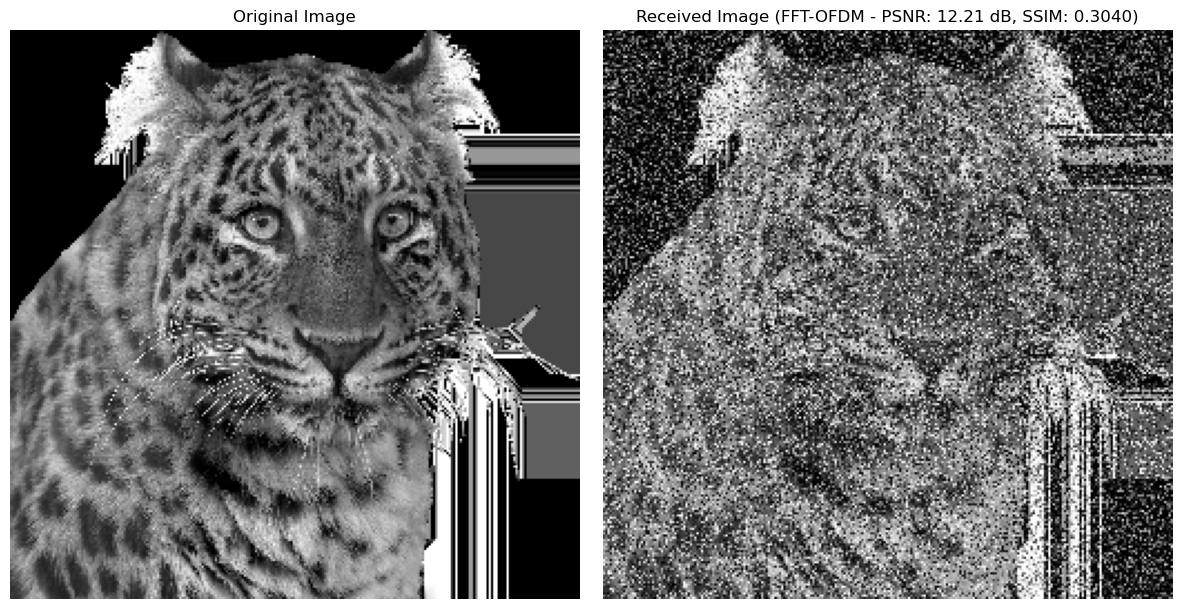

# END